In [1]:
import re
import collections
import itertools

import nltk
import nltk.data
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.metrics import BigramAssocMeasures

In [2]:
text = '''
... Punkt knows that the periods in Mr. Smith and Johann S. Bach
... do not mark sentence boundaries.
And sometimes sentences
... can start with non-capitalized words.
i is a good variable
... name.
... '''

In [3]:
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

In [4]:
sents = sent_detector.tokenize(text.strip())
sents

['Punkt knows that the periods in Mr. Smith and Johann S. Bach\ndo not mark sentence boundaries.',
 'And sometimes sentences\ncan start with non-capitalized words.',
 'i is a good variable\nname.']

In [5]:
dictionary = {}
with open('ap.txt', 'r') as file:
    string = file.read()
docs = string.split('<DOC>')
for doc in docs[1:]:
    doc_id = doc.split('DOCNO>')[1].split('</')[0].strip()
    text = doc.split('TEXT>')[1].split('</')[0].strip()
    dictionary[doc_id] = text

In [6]:
all_words = word_tokenize('\n'.join(dictionary.values()).replace('.', ''))
all_words = [word.lower() for word in all_words]

In [7]:
regexp = re.compile(r'^[a-z]+$')
#all_words = [word for word in all_words if regexp.match(word) and word not in stopwords.words('english')]
len(all_words)

1006572

In [8]:
words_by_count = collections.Counter(all_words)

In [9]:
print("Tamaño del vocabulario: {}".format(len(words_by_count)))

filtered = [(word, count) for word, count in words_by_count.items()
            if word.lower() not in stopwords.words('english') and
            re.match(r'^[a-z]+$', word)]

Tamaño del vocabulario: 41981


In [10]:
most_common = collections.Counter(**dict(filtered)).most_common(500)

In [11]:
bigram_finder = nltk.collocations.BigramCollocationFinder.from_words(all_words, window_size=15)

In [12]:
import math
most_common_words = [pair[0] for pair in most_common]
scores = {}
for i, j in itertools.combinations(most_common_words, 2):
    score_together = bigram_finder.score_ngram(BigramAssocMeasures.mi_like, i, j)
    scores[(i, j)] = math.log(score_together, 2) if score_together is not None else float('-inf')

In [13]:
sorted(scores.items(), key=lambda p: p[1], reverse=True)[:50]

[(('united', 'states'), -2.4987259435090623),
 (('new', 'york'), -3.55052969688044),
 (('soviet', 'union'), -5.974673845107143),
 (('south', 'africa'), -6.063138425933927),
 (('said', 'would'), -6.567536606670372),
 (('interest', 'rates'), -6.619765470634097),
 (('west', 'german'), -7.125291226602532),
 (('news', 'conference'), -7.184341814670004),
 (('last', 'week'), -7.231499699853994),
 (('dollar', 'yen'), -7.250961573533219),
 (('told', 'reporters'), -7.308567572584151),
 (('air', 'force'), -7.467882059930002),
 (('west', 'germany'), -7.476098707661047),
 (('years', 'ago'), -7.495089618541971),
 (('stock', 'exchange'), -7.810126370006235),
 (('news', 'agency'), -7.815378712144334),
 (('iraq', 'kuwait'), -7.874631686854079),
 (('east', 'germany'), -8.088393635543836),
 (('cents', 'lower'), -8.436582283552116),
 (('last', 'month'), -8.536267013480145),
 (('million', 'shares'), -8.616000110027182),
 (('president', 'bush'), -8.640184410606798),
 (('eastern', 'europe'), -9.0788421828864

# Información Léxica

In [14]:
import string
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

with open('origin.txt', 'r') as file:
    species = file.read()

species_words = tokenizer.tokenize(species)
species_words = [word.lower() for word in species_words]

from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()
species_lemm = []
for word in species_words:
    species_lemm.append(lmtzr.lemmatize(word))

Plant


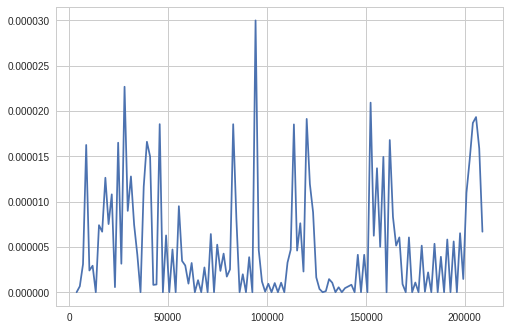

Instinct


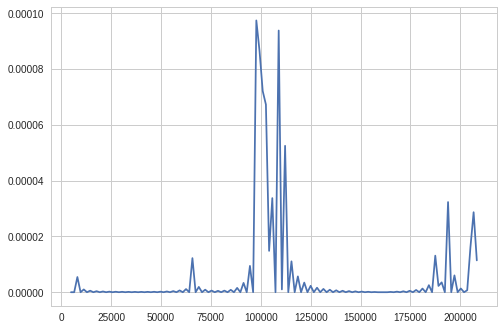

For


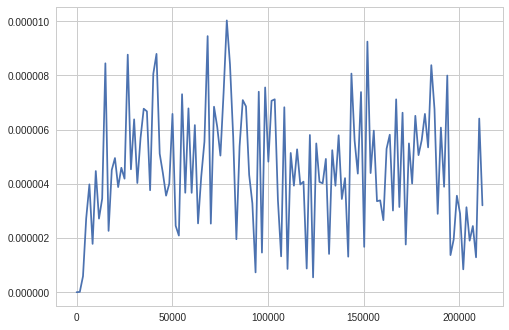

In [50]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

for_list = []
plant_list = []
instinct_list = []
for i,word in enumerate(species_lemm):
    if word == 'plant':
        plant_list.append(i)
    if word == 'instinct':
        instinct_list.append(i)
    if word == 'for':
        for_list.append(i)

sns.set_style('whitegrid')
sns.kdeplot(np.array(plant_list), bw=0.8)
print('Plant')
plt.show()

sns.kdeplot(np.array(instinct_list), bw=0.8)
print('Instinct')
plt.show()

sns.kdeplot(np.array(for_list), bw=0.8)
print('For')
plt.show()

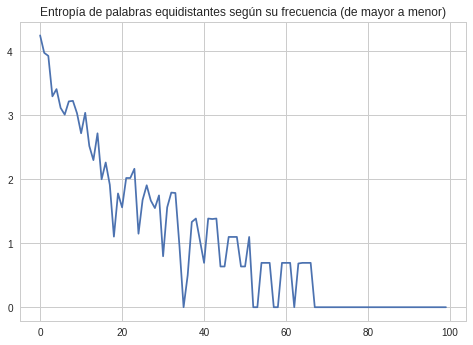

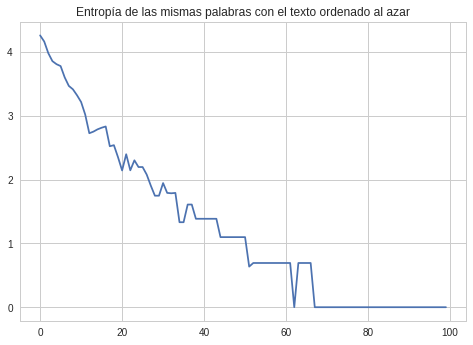

In [51]:
import numpy as np
import scipy

from collections import Counter

words_by_count = Counter(species_lemm)
words_distributed = words_by_count.most_common()[0:-1:int(len(words_by_count)/99)]  # take 100 equidistributed words

words_distributed = [w[0] for w in words_distributed]

def compute_entropy(word, text_parts):
    ps = []
    for part in text_parts:
        p = part.count(word) / len(part)
        ps.append(p)
    return scipy.stats.entropy(ps)


def plot_entropies(text):
    text_parts = [text[i:i + 3000] for i in range(0, len(text), 3000)] # take partitions of lenght 3000
    entropies = []
    for word in words_distributed:
        entropies.append(compute_entropy(word, text_parts))
        
    plt.plot(entropies)

plot_entropies(species_lemm)
plt.title("Entropía de palabras equidistantes según su frecuencia (de mayor a menor)")
plt.show()

import random
randomized = species_lemm[:]
random.shuffle(randomized)
plot_entropies(randomized)
plt.title("Entropía de las mismas palabras con el texto ordenado al azar")
plt.show()

Vemos que desordenar el texto aleatoriamente suaviza la curva de entropias, lo cual es consistente con el paper.

# Word embeddings, Word2Vec vs LSA

In [16]:
from gensim import models, corpora
from nltk.corpus import webtext

word2vec_model = models.Word2Vec(webtext.sents())

Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used
/home/nahuel/.virtualenvs/datascience/lib/python3.4/site-packages/gensim/models/word2vec.py:930: UserWarning: C extension not loaded for Word2Vec, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded for Word2Vec, training will be slow. "


In [17]:
id2word = corpora.Dictionary(webtext.sents())
corpora.MmCorpus.serialize('corpus.mm', (id2word.doc2bow(text) for text in webtext.sents()))
lsi_model = models.LsiModel(corpora.MmCorpus('corpus.mm'), id2word=id2word)

In [18]:
tests = []
with open('wordsim353_sim_rel/wordsim353_agreed.txt', 'r') as wordsim:
    tests = [line.strip().split('\t')[1:4] for line in wordsim if line[0] != '#']
#print(tests)

In [19]:
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import spatial

lsi_similarity = []
word2vec_similarity = []
human_similarity = []

max_human_value = max(v[2] for v in tests)

for word0, word1, test_value in tests:
    try:
        vec_lsi0 = [a[1] for a in lsi_model[id2word.doc2bow([word0])]]
        vec_lsi1 = [a[1] for a in lsi_model[id2word.doc2bow([word1])]]
        lsi_val = abs(1 - spatial.distance.cosine(vec_lsi0, vec_lsi1))
    except Exception: # word not found
        continue
    try:
        word2vec_val = word2vec_model.similarity(word0, word1)
    except KeyError: # word not found
        continue
    human_value = float(test_value) / float(max_human_value) # normalization
    lsi_similarity.append(lsi_val)
    word2vec_similarity.append(word2vec_val)
    human_similarity.append(human_value)
    print("{} vs {}:\tlsi {}\tw2v {}\thuman {}".format(word0, word1, lsi_val, word2vec_val, human_value))

/home/nahuel/.virtualenvs/datascience/lib/python3.4/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
/home/nahuel/.virtualenvs/datascience/lib/python3.4/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/nahuel/.virtualenvs/datascience/lib/python3.4/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


love vs sex:	lsi 0.02178343315040987	w2v 0.6787672609273203	human 0.7171610169491526
book vs paper:	lsi 0.009856696456809866	w2v 0.9701923853157364	human 0.7902542372881356
computer vs keyboard:	lsi 0.2029777299733364	w2v 0.9317328291282198	human 0.8072033898305085
computer vs internet:	lsi 0.14514133971871623	w2v 0.9555098794641671	human 0.8029661016949153
plane vs car:	lsi 0.12305433053776582	w2v 0.9524306363937785	human 0.611228813559322
train vs car:	lsi 0.10176815662997807	w2v 0.890627595256839	human 0.6684322033898304
television vs radio:	lsi 0.060581319043271575	w2v 0.9046261536158279	human 0.7171610169491526
media vs radio:	lsi 0.1085686981683971	w2v 0.9494175823283382	human 0.7860169491525424
bread vs butter:	lsi 0.12352575226771556	w2v 0.978135137369259	human 0.6557203389830509
professor vs doctor:	lsi 0.05935158141282937	w2v 0.8879340333826546	human 0.701271186440678
student vs professor:	lsi 0.12863994729970796	w2v 0.844000555085649	human 0.7213983050847458
smart vs student

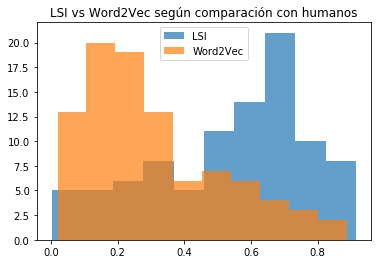

In [20]:
lsi_difference = [abs(lsi_similarity[i] - human_similarity[i]) for i in range(len(lsi_similarity))]
word2vec_difference = [abs(word2vec_similarity[i] - human_similarity[i]) for i in range(len(lsi_similarity))]
plt.hist(lsi_difference, label="LSI", alpha=0.7)
plt.hist(word2vec_difference, label="Word2Vec", alpha=0.7)
plt.legend()
plt.title('LSI vs Word2Vec según comparación con humanos')
plt.show()

Vemos que Word2Vec es superior a LSA/LSI en la comparación con humanos, dado que su distribución de diferencias es más cercana a 0.

In [21]:
from nltk.corpus import wordnet as wn
from nltk.corpus.reader.wordnet import WordNetError
import numpy as np

lch_results, path_results, wup_results = [], [], []
for test in tests:
    if not wn.synsets(test[0]) or not wn.synsets(test[1]):
        continue
    word0, word1 = wn.synsets(test[0])[0], wn.synsets(test[1])[0]
    try:
        lch = word0.lch_similarity(word1)
        path = word0.path_similarity(word1)
        wup = word0.wup_similarity(word1)
        lch_results.append(lch)
        path_results.append(path)
        wup_results.append(wup)
    except WordNetError:
        continue

assert len(lch_results) == len(path_results) == len(wup_results)

all_results = lch_results, path_results, wup_results
lsi_differences, w2v_differences = [], []

for result in all_results:
    lsi_differences.append([abs(result[i] - lsi_similarity[i]) for i in range(len(lsi_similarity))])
    w2v_differences.append([abs(result[i] - word2vec_similarity[i]) for i in range(len(word2vec_similarity))])

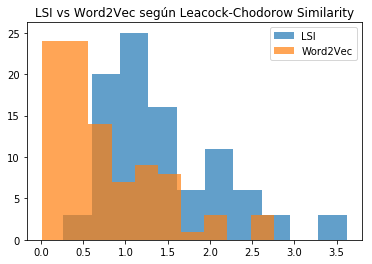

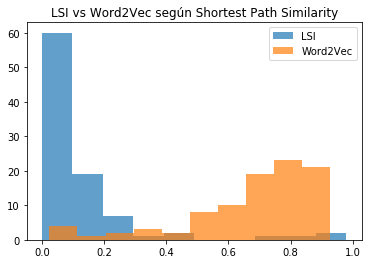

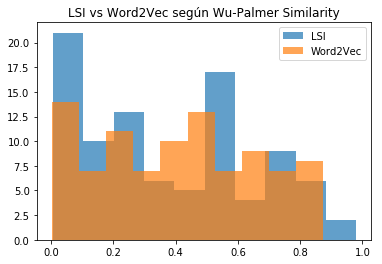

In [22]:
import matplotlib.pyplot as plt
    
def plot_hist(lsi_difference, w2v_difference, title):
    plt.hist(lsi_difference, label="LSI", alpha=0.7)
    plt.hist(w2v_difference, label="Word2Vec", alpha=0.7)
    plt.legend()
    plt.title(title)
    plt.show()

    
plot_hist(lsi_differences[0], w2v_differences[0], "LSI vs Word2Vec según Leacock-Chodorow Similarity")
plot_hist(lsi_differences[1], w2v_differences[1], "LSI vs Word2Vec según Shortest Path Similarity")
plot_hist(lsi_differences[2], w2v_differences[2], "LSI vs Word2Vec según Wu-Palmer Similarity")

Nuevamente Word2Vec supera a LSI en la similaridad de Leacock-Chodorow (que considera tanto el camino más corto como la profundidad de la taxonomía), pero LSI parece comportarse mejor considerando únicamente el camino más corto. La similaridad de Wu-Palmer (que solo considera la profundidad de la taxonomía) no sugiere ningún ganador claro.